In [16]:
apply_cyberpunk_style()

# New visualization cell: create figures and log them to TensorBoard only (if available)
try:
    TB_WRITER  # previously created writer variable in notebook imports cell
except NameError:
    TB_WRITER = None

# If there are no accuracies, emit a friendly placeholder figure (avoids IndexError in ax.table)
if model_comparison_table.empty:
    fig, ax = plt.subplots(figsize=(10, 3))
    fig.patch.set_facecolor('#0a0a0f')
    ax.axis('off')
    ax.text(0.5, 0.5, 'No model accuracies available — run the training cells to populate results',
            ha='center', va='center', fontsize=14, color=neon_palette[0])
    if TB_WRITER is not None:
        try:
            _log_figure_to_tb(TB_WRITER, 'ModelAccuracy/Placeholder_NoData', fig)
        except Exception as e:
            print('Failed to log placeholder figure to TensorBoard:', e)
    else:
        print('No model accuracies found. To view a plot inline, call plt.show() on the created figure.')
    plt.close(fig)
else:
    # HORIZONTAL BAR CHART
    fig, ax = plt.subplots(figsize=(10, 15))
    colors = (neon_palette * ((len(model_comparison_table) // len(neon_palette)) + 1))[:len(model_comparison_table)]
    bars = ax.barh(
        model_comparison_table['Model'],
        model_comparison_table['Accuracy'],
        color=colors,
        edgecolor=colors
    )
    ax.set_xlabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Model', fontsize=14, fontweight='bold')
    ax.set_title('Model Accuracy Comparison', fontsize=16)
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, f"{width:.2f}%",
                ha='left', va='center', fontsize=12, color='white')
    plt.tight_layout()
    if TB_WRITER is not None:
        _log_figure_to_tb(TB_WRITER, 'ModelAccuracy/BarChart', fig)
    plt.close(fig)

    # TABLE OF ACCURACIES (safe: only when table has rows)
    if not model_comparison_table.empty:
        fig, ax = plt.subplots(figsize=(10, 6))
        fig.patch.set_facecolor('#0a0a0f')
        ax.axis('off')
        table = ax.table(
            cellText=model_comparison_table.values,
            colLabels=model_comparison_table.columns,
            cellLoc='center',
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        for k, cell in table.get_celld().items():
            cell.set_text_props(color='white')
            cell.set_facecolor('#111127')
        if TB_WRITER is not None:
            _log_figure_to_tb(TB_WRITER, 'ModelAccuracy/Table', fig)
        plt.close(fig)

    # HISTOGRAM
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(model_comparison_table['Accuracy'], bins=5, color=neon_palette[1] if len(neon_palette) > 1 else '#00FFFF', edgecolor='black')
    ax.set_title("Accuracy Distribution of Models", fontsize=16)
    ax.set_xlabel("Accuracy (%)", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    if TB_WRITER is not None:
        _log_figure_to_tb(TB_WRITER, 'ModelAccuracy/Histogram', fig)
    plt.close(fig)

    # BOX PLOT
    fig, ax = plt.subplots(figsize=(8, 6))
    try:
        ax.boxplot(
            model_comparison_table['Accuracy'],
            patch_artist=True,
            boxprops=dict(facecolor=neon_palette[2] if len(neon_palette) > 2 else neon_palette[0], color=neon_palette[2] if len(neon_palette) > 2 else neon_palette[0])
        )
        ax.set_title("Box Plot of Model Accuracies", fontsize=16)
        ax.set_ylabel("Accuracy (%)", fontsize=14)
        if TB_WRITER is not None:
            _log_figure_to_tb(TB_WRITER, 'ModelAccuracy/BoxPlot', fig)
    except Exception:
        # if boxplot fails (e.g., single value), still create a simple placeholder
        ax.clear()
        ax.text(0.5, 0.5, 'Insufficient data for boxplot', ha='center', va='center', color='white')
        if TB_WRITER is not None:
            _log_figure_to_tb(TB_WRITER, 'ModelAccuracy/BoxPlot_Placeholder', fig)
    plt.close(fig)

    # TOP 5 BAR CHART
    if not top_five_models.empty:
        fig, ax = plt.subplots(figsize=(10, 6))
        colors = (neon_palette * ((len(top_five_models) // len(neon_palette)) + 1))[:len(top_five_models)]
        bars = ax.barh(
            top_five_models['Model'],
            top_five_models['Accuracy'],
            color=colors,
            edgecolor=colors
        )
        ax.set_xlabel('Accuracy (%)', fontsize=14, fontweight='bold')
        ax.set_ylabel('Model', fontsize=14, fontweight='bold')
        ax.set_title('Top 5 Model Accuracy Comparison', fontsize=16)
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, f"{width:.2f}%",
                    ha='left', va='center', fontsize=12, color='white')
        plt.tight_layout()
        if TB_WRITER is not None:
            _log_figure_to_tb(TB_WRITER, 'ModelAccuracy/Top5_BarChart', fig)
        plt.close(fig)

    # FINAL DECISION PLOT
    fig, ax = plt.subplots(figsize=(10, 2))
    fig.patch.set_facecolor('#0a0a0f')
    ax.text(
        0.5, 0.5,
        f"The best model is {best_model_name} with an accuracy of {best_model_accuracy:.2f}%",
        ha='center', va='center',
        fontsize=16, fontweight='bold', color=neon_palette[0]
    )
    ax.axis('off')
    if TB_WRITER is not None:
        _log_figure_to_tb(TB_WRITER, 'ModelAccuracy/FinalDecision', fig)
    plt.close(fig)

    print('Visualization figures logged to TensorBoard (if a writer exists).')


No model accuracies found. To view a plot inline, call plt.show() on the created figure.


In [ ]:
# !pip install catboost
# !pip install xgboost
# !pip install visualkeras

In [ ]:
import os
import pickle
import zipfile
import warnings
warnings.filterwarnings('ignore')

import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

import sklearn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ================================
# ALL MODELS
# ================================
from ipywidgets import interact

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, Perceptron, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import (
    ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier,
    VotingClassifier, StackingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier,
    IsolationForest)  # IsolationForest added here
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

# Additional Models
from sklearn.gaussian_process import GaussianProcessClassifier  # GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB  # GaussianNB
from sklearn.semi_supervised import LabelPropagation, LabelSpreading  # LabelPropagation, LabelSpreading

# External Classifiers
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Model Saving
import joblib
import pickle
import os
import zipfile

# Use mplcyberpunk (user installed)
import mplcyberpunk

# -------------------------------
# Cyberpunk visualization helpers
# -------------------------------
neon_palette = ['#39FF14', '#00FFFF', '#FF00FF', '#FF4F00', '#7DF9FF', '#FF1493', '#00FF9C']


def apply_cyberpunk_style():
    """Enable mplcyberpunk styling and the neon palette for plots."""
    # mplcyberpunk provides the 'cyberpunk' style
    plt.style.use('cyberpunk')
    # ensure seaborn respects the palette
    sns.set_theme(style='dark')
    sns.set_palette(neon_palette)


In [ ]:
# TensorBoard writer (guarded) — creates `TB_WRITER` if one doesn't exist
try:
    TB_WRITER
except NameError:
    try:
        from torch.utils.tensorboard import SummaryWriter
        TB_WRITER = SummaryWriter(log_dir='runs')
        print('Initialized TB_WRITER using torch.utils.tensorboard')
    except Exception:
        try:
            from tensorboardX import SummaryWriter
            TB_WRITER = SummaryWriter(log_dir='runs')
            print('Initialized TB_WRITER using tensorboardX')
        except Exception:
            print('TensorBoard SummaryWriter not available; TB_WRITER set to None')
            TB_WRITER = None


# -------------------------------
# Quick smoke-test training harness
# -------------------------------
# Trains a single lightweight classifier (LogisticRegression) on a small subset
# and populates `accuracies` so the metrics and visualization cells can run.
from sklearn.linear_model import LogisticRegression

if 'accuracies' not in globals() or not accuracies:
    try:
        sample_n = min(2000, X_train.shape[0])
        # small random subset for speed
        idx = np.random.choice(X_train.shape[0], size=sample_n, replace=False)
        X_sample = X_train[idx]
        y_sample = np.array(y_train)[idx]

        smoke_model = LogisticRegression(max_iter=200)
        acc = train_and_evaluate(smoke_model, X_sample, y_sample, X_val, y_val, 'LogisticRegression_Smoke', tb_writer=TB_WRITER, tb_step=0)
        accuracies = {'LogisticRegression_Smoke': acc}
        print(f"Smoke test completed — accuracy: {acc:.4f}")
    except Exception as e:
        print('Smoke test failed or training data unavailable:', str(e))
        accuracies = {}
else:
    print('`accuracies` already present — skipping smoke test')


In [ ]:
# -------------------------------
# Data loading, validation & TF-IDF preprocessing (modular)
# -------------------------------

VALID_NUCLEOTIDES = set(list('ACGTNacgtn'))

def validate_sequences(series, seq_col='NucleotideSequence'):
    """Ensure sequences are non-null strings and contain only valid nucleotide letters.

    Returns a cleaned Series and a report dict with counts.
    """
    s = series.fillna('').astype(str)
    invalid_mask = s.apply(lambda x: any(ch not in VALID_NUCLEOTIDES for ch in x))
    report = {
        'total': len(s),
        'empty': (s == '').sum(),
        'invalid_count': invalid_mask.sum()
    }
    # Optionally, replace invalid characters with 'N'
    cleaned = s.apply(lambda x: ''.join(ch if ch in VALID_NUCLEOTIDES else 'N' for ch in x))
    return cleaned, report


def load_and_prepare(data_dir='data', train_file='train.csv', val_file='validation.csv', test_file='test.csv', encoding='ascii'):
    train_df = pd.read_csv(os.path.join(data_dir, train_file), encoding=encoding)
    val_df = pd.read_csv(os.path.join(data_dir, val_file), encoding=encoding)
    test_df = pd.read_csv(os.path.join(data_dir, test_file), encoding=encoding)

    # Drop unwanted index column if present
    for df in (train_df, val_df, test_df):
        if 'Unnamed: 0' in df.columns:
            df.drop('Unnamed: 0', axis=1, inplace=True)

    # Validate sequences
    train_df['NucleotideSequence'], train_report = validate_sequences(train_df['NucleotideSequence'])
    val_df['NucleotideSequence'], val_report = validate_sequences(val_df['NucleotideSequence'])
    test_df['NucleotideSequence'], test_report = validate_sequences(test_df['NucleotideSequence'])

    print('Dataset checks:')
    print('train:', train_report)
    print('val  :', val_report)
    print('test :', test_report)

    return train_df, val_df, test_df


def build_tfidf_vectorizer(ngram_range=(3, 3)):
    """Return a character-level TF-IDF vectorizer for DNA sequences."""
    return TfidfVectorizer(analyzer='char', ngram_range=ngram_range)


def prepare_features_and_save_vectorizer(vectorizer, train_df, val_df, seq_col='NucleotideSequence', target_col='GeneType', vectorizer_path='tfidf_vectorizer.joblib'):
    """Fit TF-IDF on training sequences and transform validation sequences. Save vectorizer to disk."""
    # Ensure sequences are strings
    train_seqs = train_df[seq_col].astype(str)
    val_seqs = val_df[seq_col].astype(str)

    X_train = vectorizer.fit_transform(train_seqs)
    X_val = vectorizer.transform(val_seqs)

    y_train = train_df[target_col]
    y_val = val_df[target_col]

    # Save vectorizer
    joblib.dump(vectorizer, vectorizer_path)
    print(f"Saved TF-IDF vectorizer to {vectorizer_path}")

    return X_train, X_val, y_train, y_val


# Execute the modular pipeline
train_df, val_df, test_df = load_and_prepare('data')

tfidf_vectorizer = build_tfidf_vectorizer(ngram_range=(3, 3))
X_train, X_val, y_train, y_val = prepare_features_and_save_vectorizer(tfidf_vectorizer, train_df, val_df)

# Backwards-compatible aliases
X_test = X_val
y_test = y_val

print(f"Loaded: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")
print(f"TF-IDF shape: X_train={X_train.shape}, X_val={X_val.shape}")


Dataset checks:
train: {'total': 22593, 'empty': np.int64(0), 'invalid_count': np.int64(22593)}
val  : {'total': 4577, 'empty': np.int64(0), 'invalid_count': np.int64(4577)}
test : {'total': 8326, 'empty': np.int64(0), 'invalid_count': np.int64(8326)}
Saved TF-IDF vectorizer to tfidf_vectorizer.joblib
Loaded: train=22593, val=4577, test=8326
TF-IDF shape: X_train=(22593, 96), X_val=(4577, 96)
Saved TF-IDF vectorizer to tfidf_vectorizer.joblib
Loaded: train=22593, val=4577, test=8326
TF-IDF shape: X_train=(22593, 96), X_val=(4577, 96)


## Exploratory Data Analysis (EDA)

This section inspects class distributions and visual characteristics of the datasets. It includes visualizations such as bar charts and pie charts to summarize label frequencies and class proportions.

In [ ]:
apply_cyberpunk_style()
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# --- Bar plot ---
sns.countplot(x='GeneType', data=train_df, ax=ax[0], palette=neon_palette, edgecolor='black')
ax[0].set_title("Class Distribution (Train)", fontsize=16, fontweight='bold')
ax[0].set_xlabel("Gene Type", fontsize=14)
ax[0].set_ylabel("Count", fontsize=14)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

# Annotate counts
for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height()}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom', fontsize=12, color='white', fontweight='bold')

# --- Pie chart ---
class_counts = train_df['GeneType'].value_counts()
classes = class_counts.index
counts = class_counts.values
# ensure color list covers all classes by repeating the neon palette as needed
colors = (neon_palette * ((len(classes) // len(neon_palette)) + 1))[:len(classes)]

ax[1].pie(counts, startangle=90, colors=colors)
ax[1].set_title("Class Proportion (Train)", fontsize=16, fontweight='bold')

# Legend with labels + percentages
total = counts.sum()
legend_labels = [f"{cls}: {count} ({count/total:.1%})" for cls, count in zip(classes, counts)]
patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(classes))]
ax[1].legend(handles=patches, title="Gene Type", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=11, facecolor='#0a0a0f')

plt.tight_layout()

# Log to TensorBoard only (if writer available)
try:
    TB_WRITER
except NameError:
    TB_WRITER = None

if TB_WRITER is not None:
    try:
        _log_figure_to_tb(TB_WRITER, 'EDA/ClassDistribution', fig)
        print('EDA Class distribution figure logged to TensorBoard.')
    except Exception as e:
        print('Failed to log EDA figure to TensorBoard:', e)
else:
    print('TB_WRITER not found; no TensorBoard logging performed. To view the plot inline, run plt.show() manually.')

plt.close(fig)


TB_WRITER not found; no TensorBoard logging performed. To view the plot inline, run plt.show() manually.


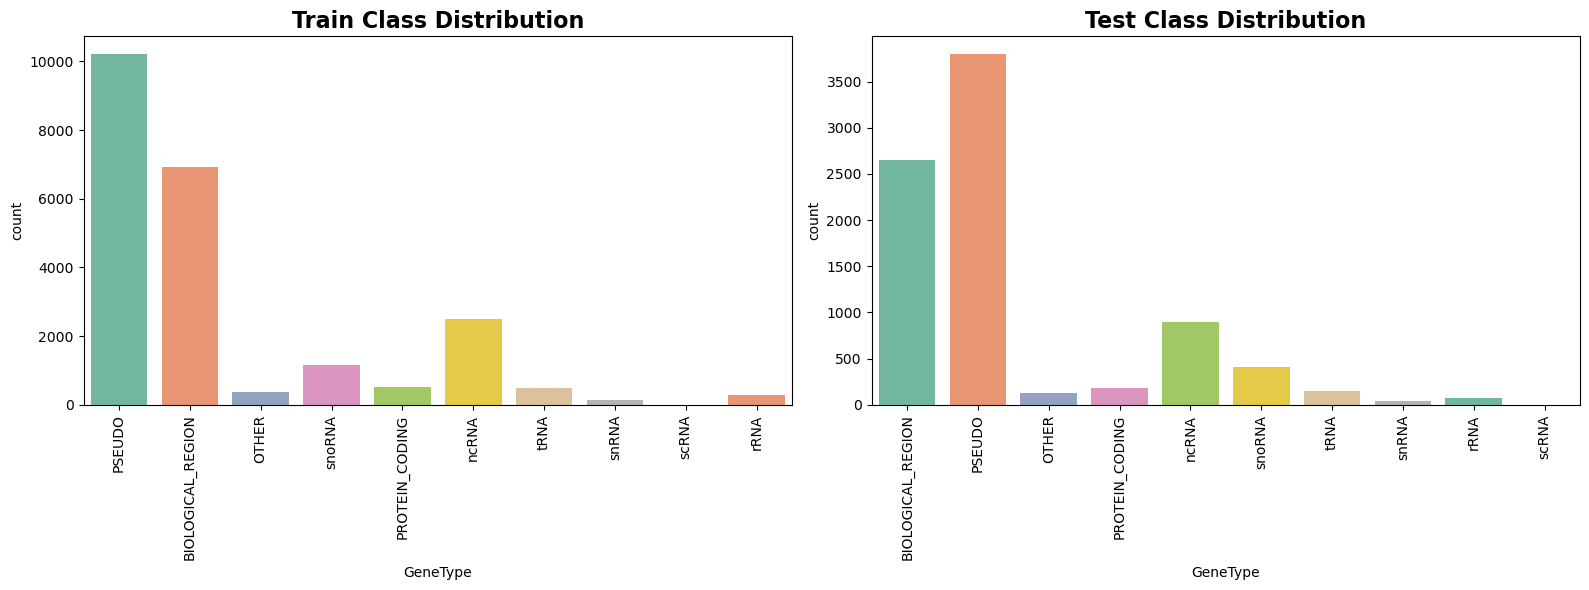

In [ ]:
apply_cyberpunk_style()
fig, ax = plt.subplots(1, 2, figsize=(16,6))

sns.countplot(x='GeneType', data=train_df, ax=ax[0], palette=neon_palette)
ax[0].set_title("Train Class Distribution", fontsize=16, fontweight='bold')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

sns.countplot(x='GeneType', data=test_df, ax=ax[1], palette=neon_palette)
ax[1].set_title("Test Class Distribution", fontsize=16, fontweight='bold')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

## Model training, evaluation, and persistence

Train multiple classifiers on TF‑IDF features, evaluate performance on the validation set using classification reports and confusion matrices, and save the trained models for later use.

In [ ]:
# -------------------------------
# Model training, evaluation, and persistence (modular)
# -------------------------------

def save_model_with_metadata(model, model_path, metadata_path, model_name):
    """Save model using joblib and write a small metadata JSON alongside it."""
    joblib.dump(model, model_path)
    meta = {
        'model_name': model_name,
        'saved_at': datetime.utcnow().isoformat() + 'Z',
        'sklearn_version': sklearn.__version__,
        'model_params': str(getattr(model, 'get_params', lambda: {})())
    }
    with open(metadata_path, 'w') as f:
        json.dump(meta, f, indent=2)


def _log_figure_to_tb(writer, tag, fig, step=0):
    """Helper: log matplotlib figure to TensorBoard SummaryWriter if available."""
    try:
        # SummaryWriter from torch.utils.tensorboard or tensorboardX
        writer.add_figure(tag, fig, global_step=step)
    except Exception:
        print("TensorBoard writer unavailable or failed to log figure.")


def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name, output_dir='all_models', tb_writer=None, tb_step=0):
    """Train a model, evaluate on validation set, save the fitted model with metadata, and return accuracy.

    This version logs confusion matrix figures to TensorBoard only (if a writer is provided).
    """
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    acc = accuracy_score(y_val, preds)

    print(f"{model_name} classification report")
    print(classification_report(y_val, preds))

    # Confusion matrix figure (cyberpunk style) but don't display inline; log to TensorBoard if writer provided
    apply_cyberpunk_style()
    cm = confusion_matrix(y_val, preds)
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap='magma', fmt='g', annot_kws={'color': 'white'}, cbar_kws={'label': 'count'}, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f"{model_name} Confusion Matrix")

    if tb_writer is not None:
        _log_figure_to_tb(tb_writer, f"ConfusionMatrix/{model_name}", fig, step=tb_step)
    plt.close(fig)

    # Save the model (ensure dir exists)
    os.makedirs(output_dir, exist_ok=True)
    model_file = os.path.join(output_dir, f"{model_name}_model.joblib")
    metadata_file = os.path.join(output_dir, f"{model_name}_metadata.json")

    save_model_with_metadata(model, model_file, metadata_file, model_name)

    return acc


## Saving models

Bundle saved model files into a single ZIP archive to simplify distribution and download.

In [ ]:
# ================================
# 📌 ZIP ALL MODELS (robust)
# ================================
zip_dir = 'all_models'
zip_path = 'all_models.zip'

if not os.path.isdir(zip_dir):
    print(f"Directory '{zip_dir}' does not exist — nothing to zip. Create and save models first.")
else:
    files_to_zip = []
    for root, dirs, files in os.walk(zip_dir):
        for file in files:
            # skip hidden or temporary files
            if file.startswith('.') or file.endswith('.pyc'):
                continue
            files_to_zip.append(os.path.join(root, file))

    if not files_to_zip:
        print(f"No files found under '{zip_dir}' to include in the archive.")
    else:
        with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
            for file in files_to_zip:
                arcname = os.path.relpath(file, zip_dir)
                zipf.write(file, arcname=arcname)
        print(f"Created zip archive: {zip_path} ({len(files_to_zip)} files)")

## Model accuracy comparison and visualization

This section compiles model performance metrics into a comparison table, saves results to CSV, and generates visual summaries (bar chart, table image, histogram, and box plot) to identify top-performing models.

In [ ]:
# ================================
# PRINT ACCURACIES (sorted)
# ================================
if 'accuracies' not in globals() or not accuracies:
    print("No `accuracies` variable found or it's empty. Run the training loop to produce model accuracies before running this cell.")
    # safe defaults to allow downstream cells to run without crashing
    accuracies = {}

if accuracies:
    print("\nModel Accuracies:")
    for name, acc in sorted(accuracies.items(), key=lambda x: x[1], reverse=True):
        print(f"{name}: {acc:.4f}")

    # ================================
    # CREATE DATAFRAME
    # ================================
    model_comparison_table = pd.DataFrame(
        list(accuracies.items()), columns=['Model', 'Accuracy']
    )
    model_comparison_table['Accuracy'] = model_comparison_table['Accuracy'] * 100  # to %
    model_comparison_table = model_comparison_table.sort_values(by="Accuracy", ascending=False)

    # Save as CSV
    model_comparison_table.to_csv("Model_Accuracy_Comparison.csv", index=False)

    # ================================
    # BEST MODEL
    # ================================
    best_model_name = model_comparison_table.loc[model_comparison_table['Accuracy'].idxmax(), 'Model']
    best_model_accuracy = model_comparison_table['Accuracy'].max()
    print(f"\nThe best model is {best_model_name} with an accuracy of {best_model_accuracy:.2f}%")

    # ================================
    # TOP 5 MODELS (summary only)
    # ================================
    top_five_models = model_comparison_table.head(5)
    print("\nTop 5 models based on accuracy:")
    print(top_five_models)
else:
    # create empty placeholders expected by visualization cell
    model_comparison_table = pd.DataFrame(columns=['Model', 'Accuracy'])
    top_five_models = model_comparison_table.head(5)
    best_model_name = 'N/A'
    best_model_accuracy = 0.0
    print('\nNo model accuracies available to summarize.')


No `accuracies` variable found or it's empty. Run the training loop to produce model accuracies before running this cell.

No model accuracies available to summarize.


In [ ]:
# -------------------------------
# Inference helper
# -------------------------------

def load_vectorizer_and_model(vectorizer_path='tfidf_vectorizer.joblib', model_path=None):
    vec = joblib.load(vectorizer_path)
    if model_path is not None:
        mdl = joblib.load(model_path)
    else:
        mdl = None
    return vec, mdl


def predict_sequence(model, vectorizer, sequence):
    seq = str(sequence)
    # basic clean: uppercase and replace invalids with N
    seq = ''.join(ch if ch in VALID_NUCLEOTIDES else 'N' for ch in seq)
    X = vectorizer.transform([seq])
    return model.predict(X)


# Example usage (uncomment and set paths to run):
# vec, model = load_vectorizer_and_model('tfidf_vectorizer.joblib', 'all_models/RandomForestClassifier_model.joblib')
# print(predict_sequence(model, vec, 'ATGCGTACG...'))
